In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import scienceplots
from models.HH import *
from models.LIF import * 
from models.Ishikevich import *
from models.morrislecar import *
from utils.load import *
from utils.compue_chi import *
from utils.compute_van_Rossum_distance import *
import matplotlib.animation as animation
from scipy.sparse import dok_matrix

In [2]:
plt.style.use('science')
plt.rcParams["figure.figsize"] = (12,7)

#### Firing rates: Roughly equal and raster plot

We are selecting initial intensity values to obtain firing rates which are approximately equal. Compare firing rates between pre and post synaptic neurons.

First, let's load the paremeters that will be constant throughout the whole experiment: the parameters of the model, the time and time interval of the simulation, and other constant parameters

In [3]:
#loading up the parameters

params_HH = load_HH()
params_LIF = load_LIF()
params_IZH =load_ISH()
params_ML = load_ML()

#time parameters
t_final = 7000
dt = 0.01

#Other constant parameters
Is = np.array([ [0, 0.05], [0.05, 0]])
V0 = -60
tau = 0.65
y0 = [-60 , -60]
w0 = [0.0007223855976593603, 0.0007223855976593603]
u0 = [0,0]
n0 = 0.2 
m0 = 0.1 
h0 = 0.6 
order = 5

We'll set a fixed seed to configure the system, and create for intensities, one for each model

In [4]:
#fixing random seed
np.random.seed(1234)

#generating the intensities
I_HH = np.zeros((int(t_final/dt),2))
I_IF = np.zeros((int(t_final/dt),2))
I_IZH = np.zeros((int(t_final/dt),2))
I_ML = np.zeros((int(t_final/dt),2))

#the noise will be common for all cases
x1 = np.random.normal(0,5,int(t_final/dt))
x2 = np.random.normal(0,5,int(t_final/dt))

I_HH[:,0] = 1.3 + 5*x1
I_HH[:,1] = 1.1 + 5*x2 
I_IF[:,0] = 2 + 5*x1
I_IF[:,1] = 1.5 + 5*x2 
I_IZH[:,0] = 2 + 5*x1
I_IZH[:,1] = 1.5 + 5*x2 
I_ML[:,0] = 0.4 + 5*x1
I_ML[:,1] = 0.35 + 5*x2 

Compute the simulations for all of  the models, turn on synaptic coupling for all of them too

In [5]:
dataHH_adjust, completeHH_adjust, matrixHH_adjust = rk_simplemodel_Rossum(dt,t_final,order,[V0,V0],[n0,n0],[m0,m0],[h0,h0],*params_HH,I_HH,Is,0.012,tau)
dataIF_adjust, completeIF_adjust, matrixIF_adjust = rk_if_Rossum(dt, t_final,order,y0,*params_LIF,I_IF,Is,0.012,tau,0.7)
dataIZH_adjust, completeIZH_adjust, matrixIZH_adjust = rk_ish_Rossum(dt,t_final,order,y0,u0,I_IZH,Is,*params_IZH,0.04,tau)
dataML_adjust, completeML_adjust, matrixML_adjust = rk_ml_Rossum(dt,t_final,2,y0,w0,*params_ML,I_ML,Is,0.008,tau)

Raster plot of the spike times

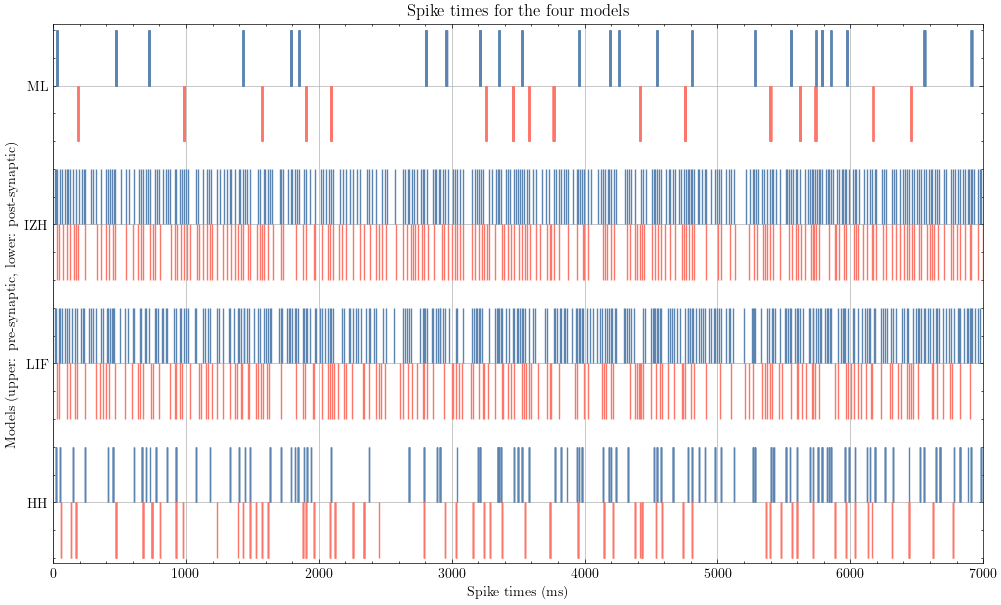

In [6]:
spike_HH_1 =  (np.argwhere(np.array(matrixHH_adjust.todense())[0,:]>0) * dt).flatten()
spike_HH_2 =  (np.argwhere(np.array(matrixHH_adjust.todense())[1,:]>0) * dt).flatten()
spike_IF_1 =  (np.argwhere(np.array(matrixIF_adjust.todense())[0,:]>0) * dt).flatten()
spike_IF_2 =  (np.argwhere(np.array(matrixIF_adjust.todense())[1,:]>0) * dt).flatten()
spike_IZH_1 =  (np.argwhere(np.array(matrixIZH_adjust.todense())[0,:]>0) * dt).flatten()
spike_IZH_2 = (np.argwhere(np.array(matrixIZH_adjust.todense())[1,:]>0) * dt).flatten()
spike_ML_1 = (np.argwhere(np.array(matrixML_adjust.todense())[0,:]>0) * dt).flatten()
spike_ML_2 = (np.argwhere(np.array(matrixML_adjust.todense())[1,:]>0) * dt).flatten()
fig, ax = plt.subplots()

ax.eventplot(spike_HH_1, color = '#5B84B1FF')
ax.eventplot(spike_HH_2,color='#FC766AFF',lineoffsets=0,label='hola')
ax.eventplot(spike_IF_2,color = '#FC766AFF',lineoffsets=2.5)
ax.eventplot(spike_IF_1, color = '#5B84B1FF', lineoffsets= 3.5)
ax.eventplot(spike_IZH_2,color = '#FC766AFF',lineoffsets= 5.0 )
ax.eventplot(spike_IZH_1, color = '#5B84B1FF', lineoffsets= 6.0)
ax.eventplot(spike_ML_2, color = '#FC766AFF', lineoffsets= 7.5)
ax.eventplot(spike_ML_1,color = '#5B84B1FF', lineoffsets= 8.5)
ax.grid()
ax.set_ylim(-0.6,9.1)
ax.set_ylabel('Models (upper: pre-synaptic, lower: post-synaptic)')
plt.yticks((0.5,3.0,5.5,8.0))
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[0] = 'HH'
labels[1] = 'LIF'
labels[2] = 'IZH'
labels[3] = 'ML'

ax.set_yticklabels(labels, color = 'black')
ax.set_xlabel('Spike times (ms)')
ax.set_xlim(0,7000)

plt.title('Spike times for the four models')

plt.show()



(0.0, 2000.0)

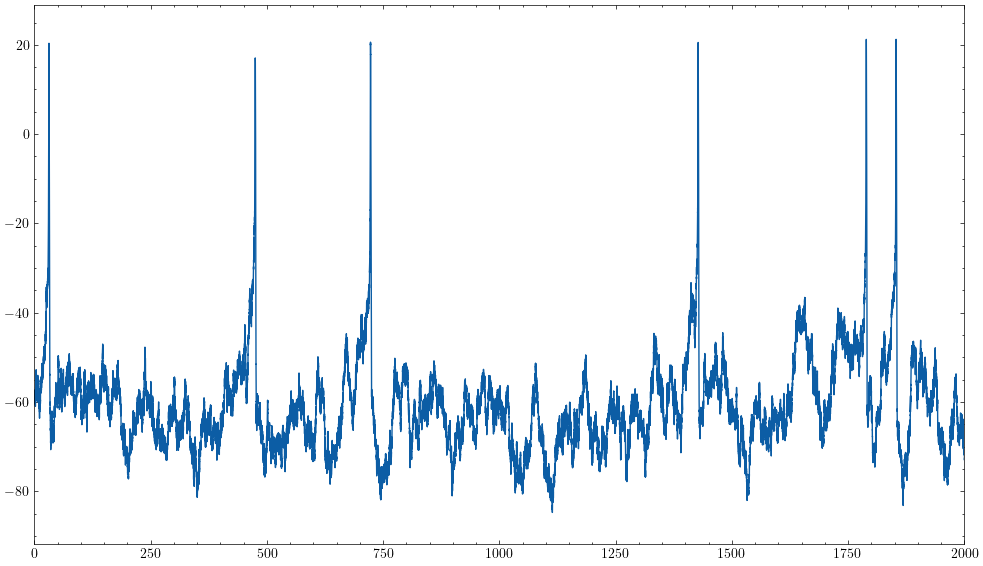

In [7]:
plt.plot(np.linspace(0,t_final,int(t_final/dt)),dataML_adjust[:,0])
plt.xlim(0,2000)

Compute and print firing rates

In [8]:
firing_HH_pre = len(spike_HH_1) / 2 * 1000 / t_final 
firing_HH_post = len(spike_HH_2) /2  *1000 / t_final
firing_IF_pre = len(spike_IF_1) / 2 * 1000 / t_final 
firing_IF_post = len(spike_IF_2) /2 *1000 / t_final
firing_IZH_pre = len(spike_IZH_1) / 2 * 1000 / t_final 
firing_IZH_post = len(spike_IZH_2) /2 *1000 / t_final
firing_ML_pre = len(spike_ML_1) / 2 * 1000 / t_final 
firing_ML_post = len(spike_ML_2) /2 *1000 / t_final

print('Pre-synaptic firing rates \n HH:',firing_HH_pre,'IF:',firing_IF_pre, 'IZH:', firing_IZH_pre, 'ML:', firing_ML_pre )
print('Post-synaptic firing rates \n HH:',firing_HH_post,'IF:',firing_IF_post, 'IZH:', firing_IZH_post, 'ML:', firing_ML_post )


Pre-synaptic firing rates 
 HH: 23.642857142857142 IF: 23.714285714285715 IZH: 23.0 ML: 23.928571428571427
Post-synaptic firing rates 
 HH: 14.357142857142858 IF: 13.142857142857142 IZH: 15.357142857142858 ML: 18.142857142857142


#### Benchmarks: Complete synchrony, completely out of phase

To start, we will compute the synchrony measurements for systems which have been tempered to be on the extremes of synchronisation, so we know what should be the maximum and minimum of the measurements. There are three different measurements, but for this experiment of only two neurons, we are going to ignore one of them

##### Peaks in mean voltage

We will leave here how we computed it, but it is not being currently used:

mean_voltage_HH = np.mean(data_HH,axis=1)
mean_voltage_IF = np.mean(data_IF,axis=1)
mean_voltage_IZH = np.mean(data_Ish,axis=1)
mean_voltage_ML = np.mean(data_ML,axis=1)

peaks_HH = len(np.argwhere(mean_voltage_HH>(-14)))
peaks_IF = len(np.argwhere(mean_voltage_IF>(-16)))
peaks_IZH = len(np.argwhere(mean_voltage_IZH>(-19)))
peaks_ML = len(np.argwhere(mean_voltage_ML>(-9)))


Computing a single simulation of the HH model at a constant intensity value

In [9]:
I = np.zeros((int(t_final/dt),2))
I[:,0] = 2.37
dataHH_benchmark, completeHH_benchmark, matrixHH_benchmark = rk_simplemodel_Rossum(dt,t_final,order,[V0,V0],[n0,n0],[m0,m0],[h0,h0],*params_HH,I,Is,0,tau)

First, we will compute the $\chi$ merasurement, which is the variance of the voltage

In [10]:
data_synchro = dataHH_benchmark
data_synchro[:,1] = dataHH_benchmark[:,0]

asyn_1 = dataHH_benchmark[900:len(dataHH_benchmark)-1,0]
asyn_2 = dataHH_benchmark[0:len(dataHH_benchmark)-1-900,0]

data_asyn = np.vstack((asyn_1,asyn_2)).T

In [11]:
chi_syn = compute_chi(data_synchro.T)
chi_asyn = compute_chi(data_asyn.T)
print('Chi synchronous:', chi_syn, 'Chi out of phase:', chi_asyn)

Chi synchronous: 0.9999999999991894 Chi out of phase: 0.43952577609195337


Now, let's obtain the Van_Rossum distance

In [12]:
matrix_syn = matrixHH_benchmark
matrix_syn[1,:] = matrixHH_benchmark[0,:]
t_syn = np.linspace(0,t_final,int(t_final/dt))

asyn_1 = matrixHH_benchmark[0,900:len(dataHH_benchmark)-1].todense()
asyn_2 = matrixHH_benchmark[0,0:len(dataHH_benchmark)-1-900].todense()

matrix_asyn = np.array(np.vstack((asyn_1,asyn_2)))
t_asyn = np.linspace(0,699099,int(699099))

In [13]:
van_Rossum_syn = compute_van_Rossum_distance(matrix_syn,t_syn,10)
van_Rossum_asyn = compute_van_Rossum_distance(matrix_asyn,t_asyn,10)
print('Van_Rossum synchronous:\n', van_Rossum_syn, '\n Van_Rossum out of phase:\n', van_Rossum_asyn)

Van_Rossum synchronous:
 [[0. 0.]
 [0. 0.]] 
 Van_Rossum out of phase:
 [[0.         0.05945529]
 [0.05945529 0.        ]]


#### Experiment 1 - Random simulations and mean syncrhonisation measurements

Obtaining a mean vlaue of chi and van_Rossum distance for 5 simulations with random seeds. 

In [14]:
#loading up the parameters

params_HH = load_HH()
params_LIF = load_LIF()
params_IZH =load_ISH()
params_ML = load_ML()

#time parameters
t_final = 7000
dt = 0.01

#Other constant parameters
Is = np.array([ [0, 0.05], [0.05, 0]])
V0 = -60
tau = 0.65
y0 = [-60 , -60]
w0 = [0.0007223855976593603, 0.0007223855976593603]
u0 = [0,0]
n0 = 0.2 
m0 = 0.1 
h0 = 0.6 
order = 5

In [15]:
#initial random seed, change
np.random.seed(1234)
n_measurements = 5

chi_HH = np.zeros(n_measurements)
chi_IF = np.zeros(n_measurements)
chi_IZH = np.zeros(n_measurements)
chi_ML = np.zeros(n_measurements)

rossum_HH = np.zeros((n_measurements,2))
rossum_IF = np.zeros((n_measurements,2))
rossum_IZH = np.zeros((n_measurements,2))
rossum_ML = np.zeros((n_measurements,2))

I_HH = np.zeros((int(t_final/dt),2))
I_IF = np.zeros((int(t_final/dt),2))
I_IZH = np.zeros((int(t_final/dt),2))
I_ML = np.zeros((int(t_final/dt),2))

t = np.linspace(0,t_final,int(t_final/dt))
t_R = 10

for i in range(0,n_measurements):

    #generation of random intensities
    x1 = np.random.normal(0,5,int(t_final/dt))
    x2 = np.random.normal(0,5,int(t_final/dt))
    I_HH[:,0] = 1.3 + 5*x1
    I_HH[:,1] = 1.1 + 5*x2 
    I_IF[:,0] = 2 + 5*x1
    I_IF[:,1] = 1.5 + 5*x2 
    I_IZH[:,0] = 2 + 5*x1
    I_IZH[:,1] = 1.5 + 5*x2 
    I_ML[:,0] = 0.4 + 5*x1
    I_ML[:,1] = 0.35 + 5*x2 

    #simulating the models
    dataHH_mean, completeHH_mean, matrixHH_mean = rk_simplemodel_Rossum(dt,t_final,order,[V0,V0],[n0,n0],[m0,m0],[h0,h0],*params_HH,I_HH,Is,0.012,tau)
    dataIF_mean, completeIF_mean, matrixIF_mean = rk_if_Rossum(dt, t_final,order,y0,*params_LIF,I_IF,Is,0.012,tau,0.7)
    dataIZH_mean, completeIZH_mean, matrixIZH_mean = rk_ish_Rossum(dt,t_final,order,y0,u0,I_IZH,Is,*params_IZH,0.04,tau)
    dataML_mean, completeML_mean, matrixML_mean = rk_ml_Rossum(dt,t_final,2,y0,w0,*params_ML,I_ML,Is,0.008,tau)


    #computing chi 
    chi_HH[i] = compute_chi(dataHH_mean.T)
    chi_IF[i] = compute_chi(dataIF_mean.T)
    chi_IZH[i] = compute_chi(dataIZH_mean.T)
    chi_ML[i] = compute_chi(dataML_mean.T)

    #computing van_Rossum distance
    rossum_HH[i] = compute_van_Rossum_distance(matrixHH_mean,t,t_R).flatten()[1:3]
    rossum_IF[i] = compute_van_Rossum_distance(matrixIF_mean,t,t_R).flatten()[1:3]
    rossum_IZH[i] = compute_van_Rossum_distance(matrixIZH_mean,t,t_R).flatten()[1:3]
    rossum_ML[i] = compute_van_Rossum_distance(matrixML_mean,t,t_R).flatten()[1:3]

chi_HH_total = np.mean(chi_HH),np.std(chi_HH)
chi_IF_total = np.mean(chi_IF),np.std(chi_IF)
chi_IZH_total= np.mean(chi_IZH),np.std(chi_IZH)
chi_ML_total = np.mean(chi_ML),np.std(chi_ML)

rossum_HH_total1 = np.mean(rossum_HH[:,0]), np.std(rossum_HH[:,0])
rossum_HH_total2 = np.mean(rossum_HH[:,1]), np.std(rossum_HH[:,1])

rossum_IF_total1 = np.mean(rossum_IF[:,0]), np.std(rossum_IF[:,0])
rossum_IF_total2 = np.mean(rossum_IF[:,1]), np.std(rossum_IF[:,1])

rossum_IZH_total1 = np.mean(rossum_IZH[:,0]), np.std(rossum_IZH[:,0])
rossum_IZH_total2 = np.mean(rossum_IZH[:,1]), np.std(rossum_IZH[:,1])

rossum_ML_total1 = np.mean(rossum_ML[:,0]), np.std(rossum_ML[:,0])
rossum_ML_total2 = np.mean(rossum_ML[:,1]), np.std(rossum_ML[:,1])

#### Experiment 2 - Random simulations with gap junction off

Repeat exactly the same experiment than before, but this time changing the gap junction to 0 for all models

In [16]:
#loading up the parameters

params_HH = load_HH()
params_LIF = load_LIF()
params_IZH =load_ISH()
params_ML = load_ML()

#time parameters
t_final = 7000
dt = 0.01

#Other constant parameters
Is = np.array([ [0, 0.05], [0.05, 0]])
V0 = -60
tau = 0.65
y0 = [-60 , -60]
w0 = [0.0007223855976593603, 0.0007223855976593603]
u0 = [0,0]
n0 = 0.2 
m0 = 0.1 
h0 = 0.6 
order = 5

In [17]:
#initial random seed, change
np.random.seed(1234)
n_measurements = 5

chi_HH_off = np.zeros(n_measurements)
chi_IF_off = np.zeros(n_measurements)
chi_IZH_off = np.zeros(n_measurements)
chi_ML_off = np.zeros(n_measurements)

rossum_HH_off = np.zeros((n_measurements,2))
rossum_IF_off = np.zeros((n_measurements,2))
rossum_IZH_off = np.zeros((n_measurements,2))
rossum_ML_off = np.zeros((n_measurements,2))

I_HH = np.zeros((int(t_final/dt),2))
I_IF = np.zeros((int(t_final/dt),2))
I_IZH = np.zeros((int(t_final/dt),2))
I_ML = np.zeros((int(t_final/dt),2))

t = np.linspace(0,t_final,int(t_final/dt))
t_R = 10

for i in range(0,n_measurements):

    #generation of random intensities
    x1 = np.random.normal(0,5,int(t_final/dt))
    x2 = np.random.normal(0,5,int(t_final/dt))
    I_HH[:,0] = 1.3 + 5*x1
    I_HH[:,1] = 1.1 + 5*x2 
    I_IF[:,0] = 2 + 5*x1
    I_IF[:,1] = 1.5 + 5*x2 
    I_IZH[:,0] = 2 + 5*x1
    I_IZH[:,1] = 1.5 + 5*x2 
    I_ML[:,0] = 0.4 + 5*x1
    I_ML[:,1] = 0.35 + 5*x2 

    #simulating the models
    dataHH_off, completeHH_off, matrixHH_off = rk_simplemodel_Rossum(dt,t_final,order,[V0,V0],[n0,n0],[m0,m0],[h0,h0],*params_HH,I_HH,Is,0,tau)
    dataIF_off, completeIF_off, matrixIF_off = rk_if_Rossum(dt, t_final,order,y0,*params_LIF,I_IF,Is,0,tau,0.7)
    dataIZH_off, completeIZH_off, matrixIZH_off = rk_ish_Rossum(dt,t_final,order,y0,u0,I_IZH,Is,*params_IZH,0,tau)
    dataML_off, completeML_off, matrixML_off = rk_ml_Rossum(dt,t_final,2,y0,w0,*params_ML,I_ML,Is,0,tau)


    #computing chi 
    chi_HH_off[i] = compute_chi(dataHH_off.T)
    chi_IF_off[i] = compute_chi(dataIF_off.T)
    chi_IZH_off[i] = compute_chi(dataIZH_off.T)
    chi_ML_off[i] = compute_chi(dataML_off.T)

    #computing van_Rossum distance
    rossum_HH_off[i] = compute_van_Rossum_distance(matrixHH_off,t,t_R).flatten()[1:3]
    rossum_IF_off[i] = compute_van_Rossum_distance(matrixIF_off,t,t_R).flatten()[1:3]
    rossum_IZH_off[i] = compute_van_Rossum_distance(matrixIZH_off,t,t_R).flatten()[1:3]
    rossum_ML_off[i] = compute_van_Rossum_distance(matrixML_off,t,t_R).flatten()[1:3]

chi_HH_total_off = np.mean(chi_HH_off),np.std(chi_HH_off)
chi_IF_total_off = np.mean(chi_IF_off),np.std(chi_IF_off)
chi_IZH_total_off= np.mean(chi_IZH_off),np.std(chi_IZH_off)
chi_ML_total_off = np.mean(chi_ML_off),np.std(chi_ML_off)

rossum_HH_total1_off = np.mean(rossum_HH_off[:,0]), np.std(rossum_HH_off[:,0])
rossum_HH_total2_off = np.mean(rossum_HH_off[:,1]), np.std(rossum_HH_off[:,1])

rossum_IF_total1_off = np.mean(rossum_IF_off[:,0]), np.std(rossum_IF_off[:,0])
rossum_IF_total2_off = np.mean(rossum_IF_off[:,1]), np.std(rossum_IF_off[:,1])

rossum_IZH_total1_off = np.mean(rossum_IZH_off[:,0]), np.std(rossum_IZH_off[:,0])
rossum_IZH_total2_off = np.mean(rossum_IZH_off[:,1]), np.std(rossum_IZH_off[:,1])

rossum_ML_total1_off = np.mean(rossum_ML_off[:,0]), np.std(rossum_ML_off[:,0])
rossum_ML_total2_off = np.mean(rossum_ML_off[:,1]), np.std(rossum_ML_off[:,1])

##### Presenting the results

In [18]:
print('HH model: \n Chi measurement for gap junction on:', chi_HH_total[0], '+-', chi_HH_total[1], '\n Chi measurement for gap junction off:', chi_HH_total_off[0], '+-', chi_HH_total_off[1])
print(' Van Rossum distance for gap junction on (cell 1):', rossum_HH_total1[0], '+-', rossum_HH_total1[1], '\n Van Rossum distance for gap junction off (cell 1)', rossum_HH_total1_off[0], '+-', rossum_HH_total1_off[1], '\n')

print('LIF model: \n Chi measurement for gap junction on:', chi_IF_total[0], '+-', chi_IF_total[1], '\n Chi measurement for gap junction off:', chi_IF_total_off[0], '+-', chi_IF_total_off[1], '\n')
print(' Van Rossum distance for gap junction on (cell 1):', rossum_IF_total1[0], '+-', rossum_IF_total1[1],  '\n Van Rossum distance for gap junction off (cell 1)', rossum_HH_total1_off[0], '+-', rossum_HH_total1_off[1], '\n')

print('IZH model: \n Chi measurement for gap junction on:', chi_IZH_total[0], '+-', chi_IZH_total[1], '\n Chi measurement for gap junction off:', chi_IZH_total_off[0], '+-', chi_IZH_total_off[1], '\n')
print(' Van Rossum distance for gap junction on (cell 1):', rossum_IZH_total1[0], '+-', rossum_IZH_total1[1],  '\n Van Rossum distance for gap junction off (cell 1)', rossum_HH_total1_off[0], '+-', rossum_HH_total1_off[1], '\n')

print('ML model: \n Chi measurement for gap junction on:', chi_ML_total[0], '+-', chi_ML_total[1], '\n Chi measurement for gap junction off:', chi_ML_total_off[0], '+-', chi_ML_total_off[1], '\n')
print(' Van Rossum distance for gap junction on (cell 1):', rossum_ML_total1[0], '+-', rossum_ML_total1[1],  '\n Van Rossum distance for gap junction off (cell 1)', rossum_HH_total1_off[0], '+-', rossum_HH_total1_off[1], '\n')

HH model: 
 Chi measurement for gap junction on: 0.521708474652373 +- 0.00579179933033045 
 Chi measurement for gap junction off: 0.49890215007181615 +- 0.004671711796171758
 Van Rossum distance for gap junction on (cell 1): 16.392331414670153 +- 15.000322177092539 
 Van Rossum distance for gap junction off (cell 1) 22.455299019846272 +- 20.641536186240895 

LIF model: 
 Chi measurement for gap junction on: 0.4995904849739242 +- 0.006144307397516064 
 Chi measurement for gap junction off: 0.49022425123104185 +- 0.005212861282476489 

 Van Rossum distance for gap junction on (cell 1): 20.220303705417034 +- 8.726274213210795 
 Van Rossum distance for gap junction off (cell 1) 22.455299019846272 +- 20.641536186240895 

IZH model: 
 Chi measurement for gap junction on: 0.547640169014656 +- 0.012090361231083976 
 Chi measurement for gap junction off: 0.48973551561231954 +- 0.006428623131184639 

 Van Rossum distance for gap junction on (cell 1): 13.696097730979346 +- 9.873230364329194 
 Van

#### Experiment 3- Study in function of the gap junction value

In [19]:
#loading up the parameters

params_HH = load_HH()
params_LIF = load_LIF()
params_IZH =load_ISH()
params_ML = load_ML()

#time parameters
t_final = 7000
dt = 0.01

#Other constant parameters
Is = np.array([ [0, 0.05], [0.05, 0]])
V0 = -60
tau = 0.65
y0 = [-60 , -60]
w0 = [0.0007223855976593603, 0.0007223855976593603]
u0 = [0,0]
n0 = 0.2 
m0 = 0.1 
h0 = 0.6 
order = 5

In [20]:
#initial random seed, change
np.random.seed(1234)
n_measurements = 5

chi_HH = np.zeros(n_measurements)
chi_IF = np.zeros(n_measurements)
chi_IZH = np.zeros(n_measurements)
chi_ML = np.zeros(n_measurements)

rossum_HH = np.zeros((n_measurements,2))
rossum_IF = np.zeros((n_measurements,2))
rossum_IZH = np.zeros((n_measurements,2))
rossum_ML = np.zeros((n_measurements,2))

I_HH = np.zeros((int(t_final/dt),2))
I_IF = np.zeros((int(t_final/dt),2))
I_IZH = np.zeros((int(t_final/dt),2))
I_ML = np.zeros((int(t_final/dt),2))

chi_HH_k = np.zeros((5,2))
chi_IF_k = np.zeros((5,2))
chi_IZH_k = np.zeros((5,2))
chi_ML_k = np.zeros((5,2))

rossum_HH_k = np.zeros((5,2))
rossum_IF_k = np.zeros((5,2))
rossum_IZH_k = np.zeros((5,2))
rossum_ML_k = np.zeros((5,2))

t = np.linspace(0,t_final,int(t_final/dt))
t_R = 10

k = 0.008

for j in range(0,5):

    for i in range(0,n_measurements):

        #generation of random intensities
        x1 = np.random.normal(0,5,int(t_final/dt))
        x2 = np.random.normal(0,5,int(t_final/dt))
        I_HH[:,0] = 1.3 + 5*x1
        I_HH[:,1] = 1.1 + 5*x2 
        I_IF[:,0] = 2 + 5*x1
        I_IF[:,1] = 1.5 + 5*x2 
        I_IZH[:,0] = 2 + 5*x1
        I_IZH[:,1] = 1.5 + 5*x2 
        I_ML[:,0] = 0.4 + 5*x1
        I_ML[:,1] = 0.35 + 5*x2 

        #simulating the models
        dataHH_k, completeHH_k, matrixHH_k = rk_simplemodel_Rossum(dt,t_final,order,[V0,V0],[n0,n0],[m0,m0],[h0,h0],*params_HH,I_HH,Is,k,tau)
        dataIF_k, completeIF_k, matrixIF_k = rk_if_Rossum(dt, t_final,order,y0,*params_LIF,I_IF,Is,k,tau,0.7)
        dataIZH_k, completeIZH_k, matrixIZH_k = rk_ish_Rossum(dt,t_final,order,y0,u0,I_IZH,Is,*params_IZH,k,tau)
        dataML_k, completeML_k, matrixML_k = rk_ml_Rossum(dt,t_final,2,y0,w0,*params_ML,I_ML,Is,k,tau)


        #computing chi 
        chi_HH[i] = compute_chi(dataHH_k.T)
        chi_IF[i] = compute_chi(dataIF_k.T)
        chi_IZH[i] = compute_chi(dataIZH_k.T)
        chi_ML[i] = compute_chi(dataML_k.T)

        #computing van_Rossum distance
        rossum_HH[i] = compute_van_Rossum_distance(matrixHH_k,t,t_R).flatten()[1:3]
        rossum_IF[i] = compute_van_Rossum_distance(matrixIF_k,t,t_R).flatten()[1:3]
        rossum_IZH[i] = compute_van_Rossum_distance(matrixIZH_k,t,t_R).flatten()[1:3]
        rossum_ML[i] = compute_van_Rossum_distance(matrixML_k,t,t_R).flatten()[1:3]

    chi_HH_k[j] = np.mean(chi_HH),np.std(chi_HH)
    chi_IF_k[j] = np.mean(chi_IF),np.std(chi_IF)
    chi_IZH_k[j]= np.mean(chi_IZH),np.std(chi_IZH)
    chi_ML_k[j] = np.mean(chi_ML),np.std(chi_ML)

    rossum_HH_k[j] = np.mean(rossum_HH[:,0]), np.std(rossum_HH[:,0])

    rossum_IF_k[j] = np.mean(rossum_IF[:,0]), np.std(rossum_IF[:,0])

    rossum_IZH_k[j] = np.mean(rossum_IZH[:,0]), np.std(rossum_IZH[:,0])

    rossum_ML_k[j] = np.mean(rossum_ML[:,0]), np.std(rossum_ML[:,0])

    k = k +0.002

#### Experiment 4 - Variation of the intensity of the noise

In [ ]:
#loading up the parameters

params_HH = load_HH()
params_LIF = load_LIF()
params_IZH =load_ISH()
params_ML = load_ML()

#time parameters
t_final = 7000
dt = 0.01

#Other constant parameters
Is = np.array([ [0, 0.05], [0.05, 0]])
V0 = -60
tau = 0.65
y0 = [-60 , -60]
w0 = [0.0007223855976593603, 0.0007223855976593603]
u0 = [0,0]
n0 = 0.2 
m0 = 0.1 
h0 = 0.6 
order = 5

In [ ]:
#initial random seed, change
np.random.seed(1234)
n_measurements = 5

chi_HH = np.zeros(n_measurements)
chi_IF = np.zeros(n_measurements)
chi_IZH = np.zeros(n_measurements)
chi_ML = np.zeros(n_measurements)

rossum_HH = np.zeros((n_measurements,2))
rossum_IF = np.zeros((n_measurements,2))
rossum_IZH = np.zeros((n_measurements,2))
rossum_ML = np.zeros((n_measurements,2))

I_HH = np.zeros((int(t_final/dt),2))
I_IF = np.zeros((int(t_final/dt),2))
I_IZH = np.zeros((int(t_final/dt),2))
I_ML = np.zeros((int(t_final/dt),2))

chi_HH_noise = np.zeros((5,2))
chi_IF_noise = np.zeros((5,2))
chi_IZH_noise = np.zeros((5,2))
chi_ML_noise = np.zeros((5,2))

rossum_HH_noise = np.zeros((5,2))
rossum_IF_noise = np.zeros((5,2))
rossum_IZH_noise = np.zeros((5,2))
rossum_ML_noise = np.zeros((5,2))

t = np.linspace(0,t_final,int(t_final/dt))
t_R = 10

noise = 3

for j in range(0,5):

    for i in range(0,n_measurements):

        #generation of random intensities
        x1 = np.random.normal(0,noise,int(t_final/dt))
        x2 = np.random.normal(0,noise,int(t_final/dt))
        I_HH[:,0] = 1.3 + 5*x1
        I_HH[:,1] = 1.1 + 5*x2 
        I_IF[:,0] = 2 + 5*x1
        I_IF[:,1] = 1.5 + 5*x2 
        I_IZH[:,0] = 2 + 5*x1
        I_IZH[:,1] = 1.5 + 5*x2 
        I_ML[:,0] = 0.4 + 5*x1
        I_ML[:,1] = 0.35 + 5*x2 

        #simulating the models
        dataHH_mean, completeHH_mean, matrixHH_mean = rk_simplemodel_Rossum(dt,t_final,order,[V0,V0],[n0,n0],[m0,m0],[h0,h0],*params_HH,I_HH,Is,0.012,tau)
        dataIF_mean, completeIF_mean, matrixIF_mean = rk_if_Rossum(dt, t_final,order,y0,*params_LIF,I_IF,Is,0.012,tau,0.7)
        dataIZH_mean, completeIZH_mean, matrixIZH_mean = rk_ish_Rossum(dt,t_final,order,y0,u0,I_IZH,Is,*params_IZH,0.04,tau)
        dataML_mean, completeML_mean, matrixML_mean = rk_ml_Rossum(dt,t_final,2,y0,w0,*params_ML,I_ML,Is,0.008,tau)


        #computing chi 
        chi_HH[i] = compute_chi(dataHH_mean.T)
        chi_IF[i] = compute_chi(dataIF_mean.T)
        chi_IZH[i] = compute_chi(dataIZH_mean.T)
        chi_ML[i] = compute_chi(dataML_mean.T)

        #computing van_Rossum distance
        rossum_HH[i] = compute_van_Rossum_distance(matrixHH_mean,t,t_R).flatten()[1:3]
        rossum_IF[i] = compute_van_Rossum_distance(matrixIF_mean,t,t_R).flatten()[1:3]
        rossum_IZH[i] = compute_van_Rossum_distance(matrixIZH_mean,t,t_R).flatten()[1:3]
        rossum_ML[i] = compute_van_Rossum_distance(matrixML_mean,t,t_R).flatten()[1:3]

    chi_HH_noise[j] = np.mean(chi_HH),np.std(chi_HH)
    chi_IF_noise[j] = np.mean(chi_IF),np.std(chi_IF)
    chi_IZH_noise[j]= np.mean(chi_IZH),np.std(chi_IZH)
    chi_ML_noise[j] = np.mean(chi_ML),np.std(chi_ML)

    rossum_HH_noise[j] = np.mean(rossum_HH[:,0]), np.std(rossum_HH[:,0])

    rossum_IF_noise[j] = np.mean(rossum_IF[:,0]), np.std(rossum_IF[:,0])

    rossum_IZH_noise[j] = np.mean(rossum_IZH[:,0]), np.std(rossum_IZH[:,0])

    rossum_ML_noise[j] = np.mean(rossum_ML[:,0]), np.std(rossum_ML[:,0])

    noise = noise + 2